# Part 4: Quantization
Completed

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-01-17 14:16:06.064662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`.  We're also specifying `kernel_quantizer = quantized_bits(bits=6,integer=0,symmetric=0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

2024-01-17 14:52:56.634484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'. The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_3',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
  1/487 [..............................] - ETA: 25:06 - loss: 1.6766 - accuracy: 0.1836WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0062s vs `on_train_batch_end` time: 0.0108s). Check your callbacks.


483/487 [============================>.] - ETA: 0s - loss: 0.9692 - accuracy: 0.6869
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 0.80424, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.80424, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 7s 7ms/step - loss: 0.9680 - accuracy: 0.6873 - val_loss: 0.8042 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 2/30
482/487 [============================>.] - ETA: 0s - loss: 0.7722 - accuracy: 0.7471
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 0.80424 to 0.75703, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.80424 to 0.75703, saving model to model_3/KERAS_check_best_model_weights.h5




Epoch 13: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 8ms/step - loss: 0.7040 - accuracy: 0.7603 - val_loss: 0.7085 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 14/30
487/487 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7603
***callbacks***
saving losses to model_3/losses.log

Epoch 14: val_loss improved from 0.70854 to 0.70823, saving model to model_3/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 0.70854 to 0.70823, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_3/KERAS_check_model_last.h5

Epoch 14: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 6ms/step - loss: 0.7029 - accuracy: 0.7603 - val_loss: 0.7082 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 15/30
481/487 [============================>.] - ETA: 0s - loss: 0.7023 - accuracy: 0.7604
***call

Epoch 27/30
487/487 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7631
***callbacks***
saving losses to model_3/losses.log

Epoch 27: val_loss improved from 0.69944 to 0.69779, saving model to model_3/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.69944 to 0.69779, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 27: saving model to model_3/KERAS_check_model_last.h5

Epoch 27: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.7631 - val_loss: 0.6978 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 28/30
481/487 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.7635
***callbacks***
saving losses to model_3/losses.log

Epoch 28: val_loss did not improve from 0.69779

Epoch 28: val_loss did not improve from 0.69779

Epoch 28: saving model to model_3/KERAS_check_model_last.h5

Epoch 28: saving model to mode

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [7]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

hls_model.compile() # Compile the model

y_qkeras = model.predict(np.ascontiguousarray(X_test)) # Predict with the pruned and quantized model
y_hls = hls_model.predict(np.ascontiguousarray(X_test)) # Predict with the compiled version of the pruned and quantized model
np.save('model_3/y_qkeras.npy', y_qkeras)
np.save('model_3/y_hls.npy', y_hls)

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Mod

/dsk/l1/misc/fgias/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Done
5188/5188 [==============================] - 6s 1ms/step


5188/5188 [==============================] - 4s 757us/step
Accuracy baseline:  0.7644457831325301
Accuracy pruned, quantized: 0.7607409638554217
Accuracy hls4ml: 0.7607409638554217


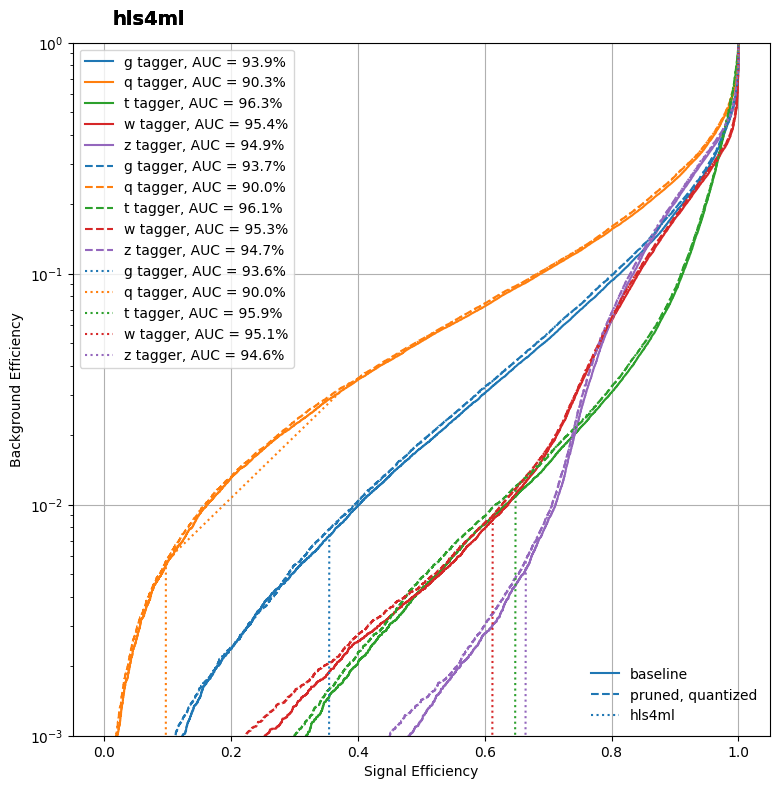

In [8]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes) # 1. The baseline model
plt.gca().set_prop_cycle(None)  # Reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--') # 2. The pruned and quantized model
plt.gca().set_prop_cycle(None)  # Reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':') # 3. The compiled version of the pruned and quantized model

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vivado_hls.log`

In [9]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /users/soft/xilinx/2019.1/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/users/soft/xilinx/2019.1/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fgias' on host 'bop' (Linux_x86_64 version 3.10.0-1160.62.1.el7.x86_64) on Wed Jan 17 15:12:53 CET 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO:

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:29 ; elapsed = 00:00:39 . Memory (MB): peak = 986.727 ; gain = 192.000 ; free physical = 8824 ; free virtual = 295975
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config10>' (firmware/nnet_utils/nnet_activation.h:40:13).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in func

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:64) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:65) by setting 'weights.V' to 'w11.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:27) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:65) by setting 'biases[0].V' to 'b11.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[12].V' to 'b8.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting '

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[28].V' to 'b8.V.28'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[12].V' to 'b5.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting '

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[28].V' to 'b5.V.28'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[15].V' to 'b2.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[16].V' to 'b2.V.16'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mo

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[33].V' to 'b2.V.33'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' 

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[50].V' to 'b2.V.50'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:216:28) to (firmware/nnet_utils/nnet_activation.h:270:1) in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>'... converting 21 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:39:74) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config7>'... converting 55 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:39:74) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config4>'... converting 121 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activatio

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 2.93 seconds; current allocated memory: 337.323 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_6_0_4_0_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<16, 6, 5, 3, 0>, ap_ufixed<6, 0, 4, 0, 0>, relu_config4>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.88 seconds; current allocated memory: 341.681 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INF

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 5.48 seconds; current allocated memory: 410.332 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_6_0_4_0_0_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_6_0_4_0_0_relu_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 8.33 seconds; current allocated memory: 44

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.034',
  'BestLatency': '10',
  'WorstLatency': '10',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '30',
  'FF': '3001',
  'LUT': '32352',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [10]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Found 1 solution(s) in model_3/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jan 17 15:21:22 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.034|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   10|   10|    1|    1| function |
    +-----+-----+-----+-----+----

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [11]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jan 17 11:08:06 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.371|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   13|   13|    1|    1| function |
    +-----+-----+-----+-----+----

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [12]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

Found 1 solution(s) in model_2/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jan 17 12:27:43 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.006|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   11|   11|    1|    1| function |
    +-----+-----+-----+-----+----

## NB
Note as well that the Vivado HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.

In [13]:
hls_model.build(synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /users/soft/xilinx/2019.1/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/users/soft/xilinx/2019.1/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fgias' on host 'bop' (Linux_x86_64 version 3.10.0-1160.62.1.el7.x86_64) on Wed Jan 17 15:37:24 CET 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10]

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:36 ; elapsed = 00:00:58 . Memory (MB): peak = 986.727 ; gain = 192.000 ; free physical = 8641 ; free virtual = 295967
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config10>' (firmware/nnet_utils/nnet_activation.h:40:13).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in func

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:64) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:239) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::softmax_idx_from_real_val<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:254) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 5, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[12].V' to 'b8.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting '

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'weights.V' to 'w5.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[0].V' to 'b5.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (a

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[17].V' to 'b5.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41-

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0' by setting 'biases[1].V' to 'b2.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::de

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[21].V' to 'b2.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[22].V' to 'b2.V.22'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dens

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[38].V' to 'b2.V.38'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[57].V' to 'b2.V.57'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:05:10 ; elapsed = 00:05:40 . Memory (MB): peak = 5198.758 ; gain = 4404.031 ; free physical = 6306 ; free virtual = 293632
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 340.93 seconds; current allocated memory: 334.230 MB.
INFO: [BIND 205-100] Starting 

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_ufixed,ap_fixed<16,6,5,3,0>,config11>.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.69 seconds; current allocated memory: 386.005 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.59 seconds; current allocated memory: 386.969 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'softmax_stable_ap_fixed_ap_fixed_16_6_5_3_0_softmax_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------



****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source vivado_synth.tcl
# set tcldir [file dirname [info script]]
# source [file join $tcldir project.tcl]
## variable project_name
## set project_name "myproject"
## variable backend
## set backend "vivado"
## variable part
## set part "xcu250-figd2104-2L-e"
## variable clock_period
## set clock_period 5
## variable clock_uncertainty
## set clock_uncertainty 12.5%
## variable version
## set version "1.0.0"
# add_files ${project_name}_prj/solution1/syn/vhdl
add_files: Time (s): cpu = 00:00:03 ; elapsed = 00:00:08 . Memory (MB): peak = 1496.816 ; gain = 51.023 ; free physical = 5734 ; free virtual = 293390
# synth_design -top ${project_name} -part $part
Command: synth_design -top myproject -part xcu250-figd2104-2L-e
Starting synth_design
Attempting to get a license for feature 'Synthe

{'CSimResults': [['0.0185547',
   '0.0761719',
   '0.571289',
   '0.268555',
   '0.173828']],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.034',
  'BestLatency': '10',
  'WorstLatency': '10',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '30',
  'FF': '3001',
  'LUT': '32352',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}